# Explainer notebook for HIMYM project


In [72]:
import twitter
import json
import csv
import numpy as np
import codecs
import math
import nltk
from nltk.corpus import stopwords
import re, string
import networkx as nx
from networkx.readwrite import json_graph
import matplotlib.pyplot as plt
import collections
import datetime
from collections import defaultdict
from collections import OrderedDict
from collections import Counter
from itertools import izip, repeat
from IPython.display import clear_output
import community
from wordcloud import WordCloud
import warnings
warnings.filterwarnings("ignore")

* **Motivation**

In this project we have worked with a dataset consisting of tweets tweeted in the timeperiod: 01.03.2014-03.04.2014 that contain #HIMYM. This dataset was chosen as the project seeks to investigate the sentiment expressed on the interwebs, whilst the final season of the series aired. In the given time-period the last 6 episodes of the series aired in the US, with the final episode airing on the 31.03.2014.

By investigating this we are hoping to create a end user experience, with neat visualizations showing how the sentiment changes, over time and over location and hopefully discover which events results in these sentiments. On top of this we are hoping that we by using community-detection will be able to create word clouds that describe the words used in tweets tweeted by specific communities (which may help uncover how these users express their sad-, mad- or happiness). This will hopefully give the end user a more nuanced image of the sentiment expressed, than just the sentiment analysis, as this does not differentiate between e.g. mad and sad tweets.

* **Basic statistics**

The dataset HIMYM_tweets.csv was fetched by using this [program](https://github.com/Jefferson-Henrique/GetOldTweets-python), and calling the following in the command prompt: 

*python Exporter.py --querysearch "#HIMYM" --since 2014-03-01 --until 2014-04-03 *


Uncleaned, the dataset takes up 28 MB and consists of:

In [2]:
#read in the tweets and save in list of dictionaries
with open('HIMYM_tweets.csv') as csvfile:
    reader = csv.DictReader(csvfile, delimiter=";")
    input_list = list(reader)

print '%d tweets' % len(input_list)

289615 tweets


The variables this dataset consists of are: 

In [3]:
print input_list[0].keys()

['username', '', 'permalink', 'text', 'hashtags', 'retweets', 'favorites', 'date', 'mentions', 'geo', 'id']


Where we will be focusing on the variables username, text, hashtag and date. The dataset is cleaned and preprocessed in the Tools, theory and analysis-section below, before any analysis is performed - after this cleaning the datasat consists of 265.625 tweets.

In this cleaning/preprocessing we remove elements from the tweet-text that will not be useful in our sentiment-analysis - this is e.g. links, mentions, non-english word, stop-words and certain hashtags that appear in the majority of the tweets. It is also chosen to remove non-ascii code, as we are only working with english text in the sentiment analysis, and choose to ignore smileys and other symbols.

The graph that is created, is made by connecting users who have written tweets with similar sentiment-value and that contains at least one of the same hashtags. The nodes in the graph is naturally users, and the node-attributes is the average sentiment for the tweets created by that user and the tokens and hashtags from the tweets created by that user. The tokens are included as these are needed for creating the wordclouds. Some basic statistics for this graph will be shown here:

In [123]:
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

G = read_json_file('graph_with_edges_sentiment01.json')

In [194]:
#print number of nodes and edges

print 'The number of nodes in the graph is: %d' % G.number_of_nodes()
print 'The number of edges in the graph is: %d' % G.number_of_edges()


#and do the same for only the connected component, we will be working with:
GCC = max(nx.connected_component_subgraphs(G), key=len)
print '\nFor the giant connected component:'
print 'The number of nodes in the GCC is: %d' % GCC.number_of_nodes()
print 'The number of edges in the GCC is: %d' % GCC.number_of_edges()

The number of nodes in the graph is: 36335
The number of edges in the graph is: 459899

For the giant connected component:
The number of nodes in the GCC is: 22865
The number of edges in the GCC is: 456472


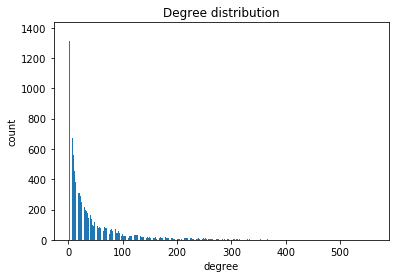

In [196]:
#create bar plot of the degree distribution: 
data_min = min(GCC.degree().values())
data_max = max(GCC.degree().values())

v = range(data_min,data_max+1)

hist, bins = np.histogram(list(GCC.degree().values()), bins=v)

bincenters = 0.5*(bins[1:]+bins[:-1])

width = 0.7 * (bins[1] - bins[0])
plt.bar(bincenters, hist, align='center', width=width)
plt.title('Degree distribution')
plt.xlabel('degree')
plt.ylabel('count')
plt.show()

As expected we see the kind of degree distribution that real networks have: a skewed degree distribution in which most nodes have only few links, and few nodes have extremely many links (so called hubs).

* **Tools, theory and analysis. **

## Sentiment analysis

We wish to compute the sentiment of the tweet-texts in our dataset, and use this to create visualizations of sentiment over time and location. This will be done by using the function seen below. This function reads in a list of words/tokens and then compute an average sentiment value for the list by looking up the words in the LabMT sentiment word list. This word list consist of 10.222 unique words, that all has an average happiness value attached to them.


In [4]:
#read in the sentiment-wordlist and create sentiment functions:
f = codecs.open('Data_Set_S1.txt','r','utf8')
# skip the first line
f.readline()

tmpDict = dict([(line.split(u'\t')[0].rstrip(u'"').lstrip(u'"'),[x.rstrip(u'"') for x in line.split(u'\t')[1:]]) for line in f])

#function that computes average sentiment of a list of tokens
def sentiment(token):
    
    #if the word w in the token is in the word list (the keys) we save the corresponding 2. value (average happiness)
    ext_val = [tmpDict.values()[tmpDict.keys().index(w)][1] for w in token if w in tmpDict.keys()]
    
    #if ext_val is an empty list the function will exit
    if not ext_val:
        return -1
    
    #otherwise the sentiment is returned (first the values are converted from strings to floats)
    ext_val = [float(i) for i in ext_val]
    return np.average(ext_val)


### Cleaning and preprocessing data
Before using this function we must convert the tweet-texts (strings) to lists of tokens, that can be compared to the words in the sentiment word list. This conversion can be seen below for all of the tweets - where we also compute the sentiment and only save the tweets that express a sentiment. On top of that we also create a list that only consists of tweets that expresses sentiment and has at least one hashtag,  as this is needed for the graph we will create later. To avoid creating an extremely dense graph it is chosen to exclude the most used hashtags: #himym, #howimetyourmother, #himymfinale, #himymfarewell and #tvtag.

Before tokenizing the strings we clean them by removing e.g. links, user mentions and non-ascii code. This is easily done by using regular expression, as we then know that we are looking for something that e.g. starts with 'https://', '@' or '\'. After having tokenized the text, we lemmatize the tokens and remove the non-english words and stop-words. It is chosen to lemmatize instead of simply stemming the words, because e.g. such an important word in our data as 'cry'/'crying', would be stemmed into 'cri' and would then be removed because it is non-english. When working with tweet-texts one can also run into such words as 'yesssss' which lemmatizers can handle:

In [21]:
#remove links, #HIMYM, #, @user, punctuations, non-english words, stop-words and tweets with no text, and tokenize and compute sentiment

cleaned_dicts = []
hashtag_dict = []

stopword=stopwords.words('english')
english_vocab = set(w.lower() for w in nltk.corpus.words.words())


for i in range(0,len(input_list)):
    
    clear_output()   
    print("i: %d " % i)
    
    #remove the hashtags #himym, #himymfinale, #himymfarewell, #howimetyourmother and #tvtag and tokenize the other hashtags
    hashtag = input_list[i]['hashtags']
    hashtag = re.sub(r'#himym\b', '', hashtag.lower())
    hashtag = re.sub(r'#himymfinale','',hashtag)
    hashtag = re.sub(r'#himymfarewell','',hashtag)
    hashtag = re.sub(r'#howimetyourmother','',hashtag)
    hashtag = re.sub(r'#tvtag','',hashtag)
    hashtag = hashtag.replace('#','')
    hashtag = nltk.word_tokenize(hashtag)
    
    #remove the space that in some of the tweets is between http:// and the rest of the address
    sent = input_list[i]["text"].replace('http:// ', 'http://')
    
    #then remove the hyperlink
    sent = re.sub(r'https?:\/\/.*\/\w*','',sent)
    
    #remove tickers
    sent = re.sub(r'\$\w*','',sent) 
    
    #remove non-ascii code (as we are only working with english text):
    sent = re.sub(r'[^\x00-\x7F]+',' ',  sent)
    
    # Remove puncutations like 's
    sent = re.sub(r'['+string.punctuation+']+', ' ', sent)
    
    #remove # and #HIMYM and #himym from the tweet text
    sent = sent.replace("HIMYM",'').replace("himym",'').replace("#",'')
    
    #remove user mentions: 
    sent = re.sub('(@[A-Za-z0-9]+)', '', sent)
    
    #tokenize the tweet
    tokens = nltk.word_tokenize(sent)
    
    #lemmatize the tokens
    tokens = set([nltk.wordnet.WordNetLemmatizer().lemmatize(w.lower()) for w in tokens])
    
    #lowercase and save tokens if they are english, not stopwords and not to short    
    tokens =  [j.lower() for j in tokens if j.lower() not in stopword and len(j) > 2 and
                                                     j.lower() in english_vocab]  

    #if the token isnt empty we compute the sentiment:
    if len(tokens) is not 0: 
        senti = sentiment(tokens)
        
        #if the tweet (tokens) has a sentiment value we save the tweet (with tokens and computed sentiment-value)
        if senti is not -1:
            new_dict = input_list[i]
            new_dict["tokens"] = list(tokens)
            new_dict["sentiment"] = senti
            new_dict['hashtags'] = hashtag
            
            cleaned_dicts.append(new_dict)
            
            #we also create a list which must also have hashtags, as this is needed when creating our graph later
            if len(hashtag) != 0: 
                hashtag_dict.append(new_dict)

i: 289614 


In [26]:
#save the new list of dictionaries: 
#with open('cleaned_dicts.json', 'w') as fout:
 #   json.dump(cleaned_dicts, fout)
    
#with open('hashtag_dict.json', 'w') as fout:
 #   json.dump(hashtag_dict, fout)
    
#getting the saved list
with open('cleaned_dicts.json') as json_data:
    cleaned_dicts = json.load(json_data)
    
with open('hashtag_dict.json') as json_data:
    hashtag_dict = json.load(json_data)

#Revert the list such that the oldest tweets come first
cleaned_dicts = list(reversed(cleaned_dicts))
hashtag_dict = list(reversed(hashtag_dict))

#I just noticed that cleaned_dicts[21490] is from february 12th, so we remove it: 
del cleaned_dicts[21490]

### Visualizing sentiment
Having computed the sentiment for all of the tweets, we can now visualize it. The most obvious visualization is created by simply showing the sentiment over a timeline. Several tweets were created at the same time, so an average sentiment value is found for tweets created in the same hour. Dashed lines are plotted where the new episodes airs:

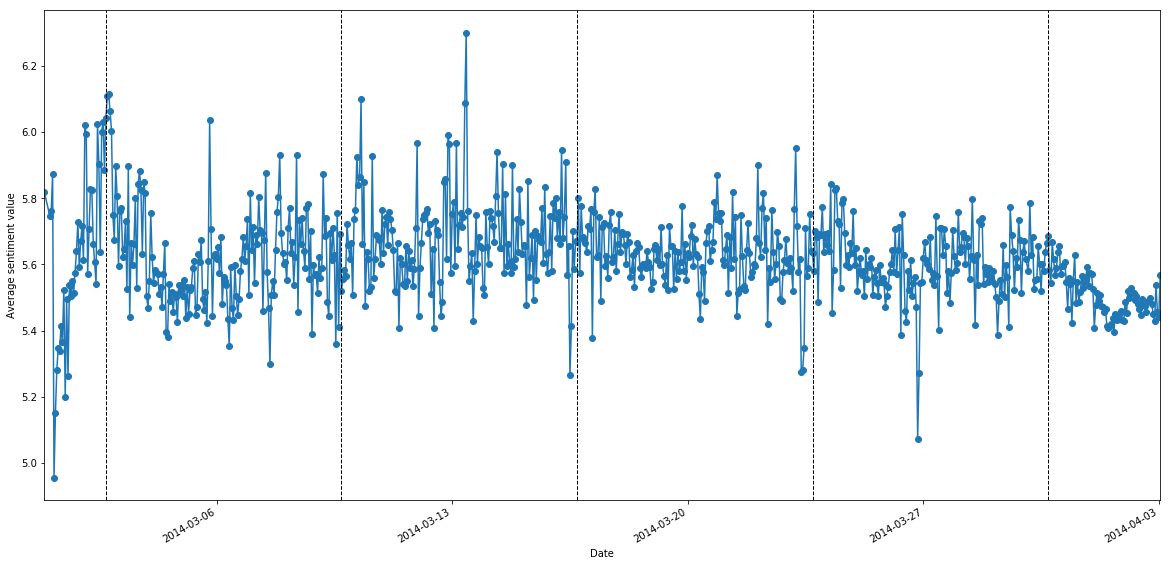

In [26]:
#first we group together all tweets created in the same hour: 
by_hour = collections.defaultdict(list)
mod_list = []
sent = []

for i in range(0,len(cleaned_dicts)):
    
    date_time = cleaned_dicts[i]['date']

    date = [int(k) for k in date_time[0:10].split("-") ]
    time = [int(j) for j in date_time[11:-1].split(':')]
    
    #date and time and datetime format
    dt_time = datetime.datetime(day=date[0], month=date[1], year=date[2], hour=time[0], minute = time[1])

    #round down to nearest hour
    mod_hour = datetime.datetime(*dt_time.timetuple()[:4])
    if mod_hour == datetime.datetime(2014, 2, 12, 18, 0):
        print i
        
    mod_list.append(mod_hour)
    by_hour[mod_hour].append(cleaned_dicts[i]['sentiment'])

#list of date-time rounded to nearest hour, used to call the grouped list: 
mod_list = list(OrderedDict(izip(mod_list, repeat(None)))) 

#average the tweets that have the same date-time
for i in range(0,len(mod_list)): 
    
    by_hour[mod_list[i]] = np.average(by_hour[mod_list[i]])
    sent.append(by_hour[mod_list[i]])


#plot with dashed lines showing where new episodes are released
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot_date(mod_list, sent, linestyle = '-')
fig.autofmt_xdate()
ax.set_xlim([mod_list[0],mod_list[-1]])
plt.xlabel('Date')
plt.ylabel('Average sentiment value')

plt.axvline(x=mod_list[41],linestyle = '--', color = (0.0, 0.0, 0.0),linewidth = 1)
plt.axvline(x=mod_list[209],linestyle = '--', color = (0.0, 0.0, 0.0),linewidth = 1)
plt.axvline(x=mod_list[377],linestyle = '--', color = (0.0, 0.0, 0.0),linewidth = 1)
plt.axvline(x=mod_list[545],linestyle = '--', color = (0.0, 0.0, 0.0),linewidth = 1)
plt.axvline(x=mod_list[712],linestyle = '--', color = (0.0, 0.0, 0.0),linewidth = 1)

plt.show()

As we are averaging over a big chunk of data (in many hours more than 1000 tweets are written), we also show the sentiment which is computed seperately for each tweet for parts of the timeline. Below is plotted the sentiment expressed in the tweets created the 05-03-2017 19-20.00 - this one is chosen as it has a high sentiment peak in the graph above, but a lot of the tweets written in this hour are concerned about the fact that the mother might be dying: 

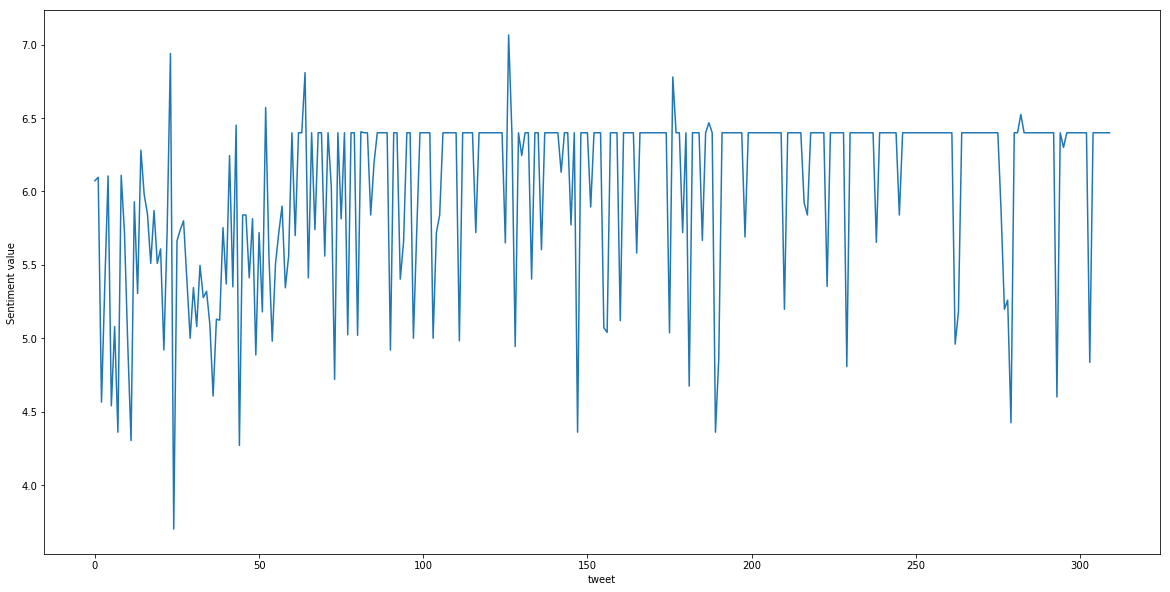

In [27]:
#find the tweets created the 5/3 in the 19. hour: 
resultlist = [d['sentiment'] for d in cleaned_dicts if '05-03-2014 19' in d.get('date', '')]

#plot the sentiment computed for these tweets: 
plt.figure(figsize=(20,10))
plt.plot(resultlist)
plt.xlabel('tweet')
plt.ylabel('Sentiment value')
plt.show()

As expected the peaks in this hour are both low and high, but the majority decides that this hour is happy. We note that when working with HIMYM tweet data these timeline does not give a very nuanced image of the sentiment expressed, as it e.g. isn't possible to see whether the tweets are mad or sad. To visualize this more clearly we find the most used hashtags, and manually choose a few that seems to reflect happy, mad and sad sentiment. The sentiment is then visualized for tweets that contain these hashtags:  

In [28]:
#find the most used hashtags
hashlist = [d['hashtags'] for d in hashtag_dict]
hashlist = [item for sublist in hashlist for item in sublist]

x = Counter(hashlist)
mostcommon = x.most_common(200)

mostcommon

[('legendary', 1611),
 ('finale', 1008),
 ('ccavm', 854),
 ('lastforever', 834),
 ('friends', 635),
 ('paleyfest', 631),
 ('barneystinson', 546),
 ('tedmosby', 545),
 ('himymwedding', 514),
 ('seriesfinale', 493),
 ('barney', 485),
 ('ted', 424),
 ('cbs', 414),
 ('psych', 384),
 ('sad', 367),
 ('spoilers', 367),
 ('fwbl', 364),
 ('robin', 356),
 ('suitup', 342),
 ('love', 313),
 ('lost', 311),
 ('finalepisode', 290),
 ('spoileralert', 289),
 ('thewalkingdead', 284),
 ('himymcharity', 270),
 ('dexter', 261),
 ('crying', 253),
 ('daisy', 248),
 ('twd', 242),
 ('endofanera', 233),
 ('nw', 231),
 ('waitforit', 223),
 ('fb', 222),
 ('spoiler', 222),
 ('pamfryman', 213),
 ('bluefrenchhorn', 208),
 ('himyd', 207),
 ('farewellhimym', 202),
 ('bittersweet', 199),
 ('2brokegirls', 197),
 ('tears', 196),
 ('bestshowever', 194),
 ('legenwaitforitdary', 193),
 ('marshall', 190),
 ('awesome', 187),
 ('sosad', 187),
 ('wtf', 184),
 ('truestory', 182),
 ('teenwolf', 181),
 ('disappointed', 176),
 ('th

We choose:

* Happy hashtags: #awesome, #bestshowever, #love
* Mad hashtags: #bittersweet, #disappointed, #wtf
* Sad hashtags: #sad, #crying, #tears

The tweets containing these hashtags', sentiment are plotted below:

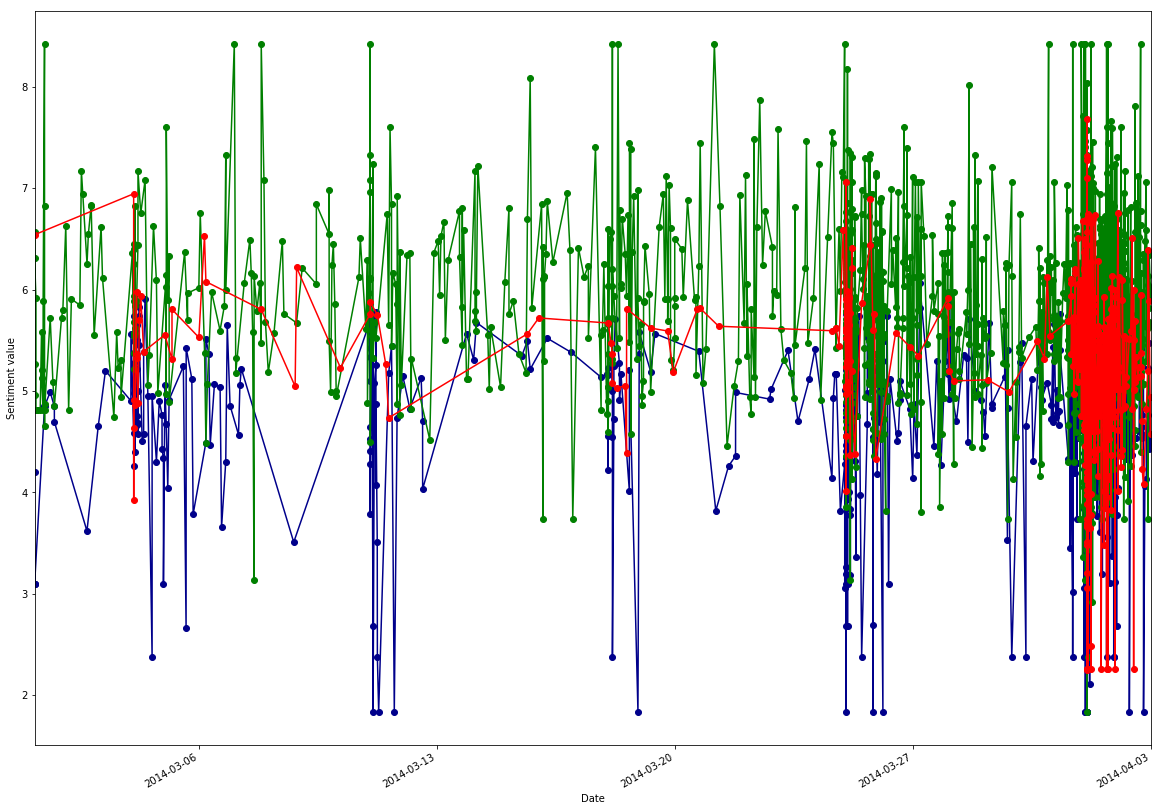

In [29]:
#find the tweets containing the sad, mad and happy hashtags:
resultlist = [d for d in cleaned_dicts if 'sad' in d.get('hashtags', '') or 'tears' in d.get('hashtags', '') or 'crying' in d.get('hashtags', '')  ]
resultlisthappy = [d for d in cleaned_dicts if 'legendary' in d.get('hashtags', '') or 'bestshowever' in d.get('hashtags', '') or 'love' in d.get('hashtags', '')  ]
resultlistmad = [d for d in cleaned_dicts if 'disappointed' in d.get('hashtags', '') or 'bittersweet' in d.get('hashtags', '') or 'wtf' in d.get('hashtags', '')  ]

#resultlist = [d for d in cleaned_dicts if 'tears' in d.get('hashtags', '')]
#resultlisthappy = [d for d in cleaned_dicts if 'bestshowever' in d.get('hashtags', '')]
#resultlistmad = [d for d in cleaned_dicts if 'disappointed' in d.get('hashtags', '')]


#plot the sentiment of tweets containiing the given hashtag
date_list = []
sent = []
date_listhappy = []
senthappy = []
date_listmad = []
sentmad = []


for i in range(0,len(resultlist)):
    
    date_time = resultlist[i]['date']

    date = [int(k) for k in date_time[0:10].split("-") ]
    time = [int(j) for j in date_time[11:-1].split(':')]
    
    #date and time and datetime format
    dt_time = datetime.datetime(day=date[0], month=date[1], year=date[2], hour=time[0], minute = time[1])

    sent.append(resultlist[i]['sentiment'])
    date_list.append(dt_time)
    
for i in range(0,len(resultlisthappy)):
    
    date_time = resultlisthappy[i]['date']

    date = [int(k) for k in date_time[0:10].split("-") ]
    time = [int(j) for j in date_time[11:-1].split(':')]
    
    #date and time and datetime format
    dt_time = datetime.datetime(day=date[0], month=date[1], year=date[2], hour=time[0], minute = time[1])

    senthappy.append(resultlisthappy[i]['sentiment'])
    date_listhappy.append(dt_time)
    
for i in range(0,len(resultlistmad)):
    
    date_time = resultlistmad[i]['date']

    date = [int(k) for k in date_time[0:10].split("-") ]
    time = [int(j) for j in date_time[11:-1].split(':')]
    
    #date and time and datetime format
    dt_time = datetime.datetime(day=date[0], month=date[1], year=date[2], hour=time[0], minute = time[1])

    sentmad.append(resultlistmad[i]['sentiment'])
    date_listmad.append(dt_time)


#plot 
fig, ax = plt.subplots(figsize=(20, 15))
ax.plot_date(date_list, sent, linestyle = '-',color = 'darkblue')
ax.plot_date(date_listhappy, senthappy, linestyle = '-',color = 'green')
ax.plot_date(date_listmad, sentmad, linestyle = '-',color = 'red')
fig.autofmt_xdate()
ax.set_xlim([date_list[0],date_list[-1]])
plt.xlabel('Date')
plt.ylabel('Sentiment value')
plt.show()

We note that their seems to be a tendency for sad tweets to express lower sentiment than mad tweets (red = mad, blue = sad, green = happy), and for all hashtags we especially notice a high concentration of tweets with peaking sentiment in the timeperiod where the last episode aired, and sad peaks near the airing of all new episodes.

### Sentiment map
Finally we will visualize the sentiment expressed in the tweets on a map over time, to see if it is related to the user's location - because when working with tweets about a series only over a timeline, one can't differentiate between sad tweets made by people who just saw the last episode and happy tweets made by people who live in a country where the last season first aired at the same time:

## Network analysis

With network analysis we are hoping to create a graph of the twitter-users, in which we can find communities and create word clouds that describe the content of the tweets created by these users. Hopefully these wordclouds will leave the end user with a clearer image of what was tweeted by e.g. mad, sad and happy users, to figure out what they are so mad/sad/happy about. 


### Creating the network
We create an undirected graph by connecting all users that has created tweets with similar sentiment-value, containing at least one of the same hashtags. Naturally the hashtags #HIMYM and #himym are not included, as all users otherwise would be connected, and on top of that we do not include #himymfinale, #himymfarewell, #howimetyourmother and #tvtag as mentioned earlier, as these also occur in a majority of the tweets. 

First we create the nodes, which has the attributes 'tokens', 'sentiment' and 'hashtags' which is combinations of all of the tweets that the given user has written: 

In [71]:
#function that searches through list of dictionaries to find dicts based on value of key:
def search_dictionaries(key, value, list_of_dictionaries):
    return [element for element in list_of_dictionaries if element[key] == value]

#list where users can occur several times
users_all = [dicts["username"] for dicts in hashtag_dict]

#make a list where users writing several tweets are only mentioned once
users = list(set(users_all))

#create a graph where the nodes are the users:

G = nx.Graph()
G.add_nodes_from(users)

#loop through the nodes and add the attributes that are used for creating the links later
for i in range(0,len(G.nodes())):
    
    clear_output()   
    print("i: %d " % i)
    
    current_user = G.nodes()[i]
        
    #find the tweets (dicts) that the user has written
    dicts_user = search_dictionaries('username', current_user, hashtag_dict)
    
    #loop through the tweets, if user has written several and combine tokens and hashtags, and average sentiment 
    combined_hashtags = [dictionary['hashtags'] for dictionary in dicts_user]
    combined_hashtags = [item for sublist in combined_hashtags for item in sublist]   #flatten list
    combined_hashtags = list(set(combined_hashtags))                                  #remove duplicates
    
    combined_tokens = [dictionary['tokens'] for dictionary in dicts_user]
    combined_tokens = [item for sublist in combined_tokens for item in sublist]       #flatten list
    
    aver = [dictionary['sentiment'] for dictionary in dicts_user]
    average_sentiment = np.average(aver)


    #set node attributes
    G.node[current_user]['hashtag'] = combined_hashtags
    G.node[current_user]['tokens'] = combined_tokens
    G.node[current_user]['sentiment'] = average_sentiment


i: 36334 


In [97]:
#save graph:
#data = json_graph.node_link_data(G)
#with open('graph_no_edges_sentiment.json', 'w') as f:
 #   json.dump(data, f, indent=4)
    

#read in graph: 
def read_json_file(filename):
    with open(filename) as f:
        js_graph = json.load(f)
    return json_graph.node_link_graph(js_graph)

G = read_json_file('graph_no_edges_sentiment.json')


And then edges are created between users who have written tweets, with similar sentiment values (+/- 0.1), containing at least one of the same hashtags: 

In [98]:
#create edges between nodes containing the same hashtags
for i in range(0,len(G.nodes())):
    
    current_user = G.nodes()[i]
    current_hashtags = G.node[current_user]['hashtag']
        
    #loop through hashtags for given node and find nodes that contain similar hashtags
    for j in range(0,len(current_hashtags)):
    
        clear_output()   
        print("i: %d j: %d " % (i,j))
        
        nodeswithhash = filter(lambda (n, d): current_hashtags[j] in d['hashtag'], G.nodes(data=True))
    
        #create edge between current node and nodes with similar hashtags
        if nodeswithhash:
            
            for k in range(0,len(nodeswithhash)):
                
                #only add and edge if the tweets express similar sentiment-value and if the two users is not the same user:
                if current_user != nodeswithhash[k][0] and G.node[nodeswithhash[k][0]]['sentiment'] < G.node[current_user]['sentiment']+0.1 and G.node[nodeswithhash[k][0]]['sentiment'] > G.node[current_user]['sentiment']-0.1:
        
                    G.add_edge(current_user, nodeswithhash[k][0])

i: 36334 j: 0 


In [32]:
#save graph:
data = json_graph.node_link_data(G)
with open('graph_with_edges_sentiment01.json', 'w') as f:
    json.dump(data, f, indent=4)

#def read_json_file(filename):
 #   with open(filename) as f:
  #      js_graph = json.load(f)
   # return json_graph.node_link_graph(js_graph)

#G = read_json_file('graph_with_edges_sentiment01.json')


Below we draw the graph for all nodes:

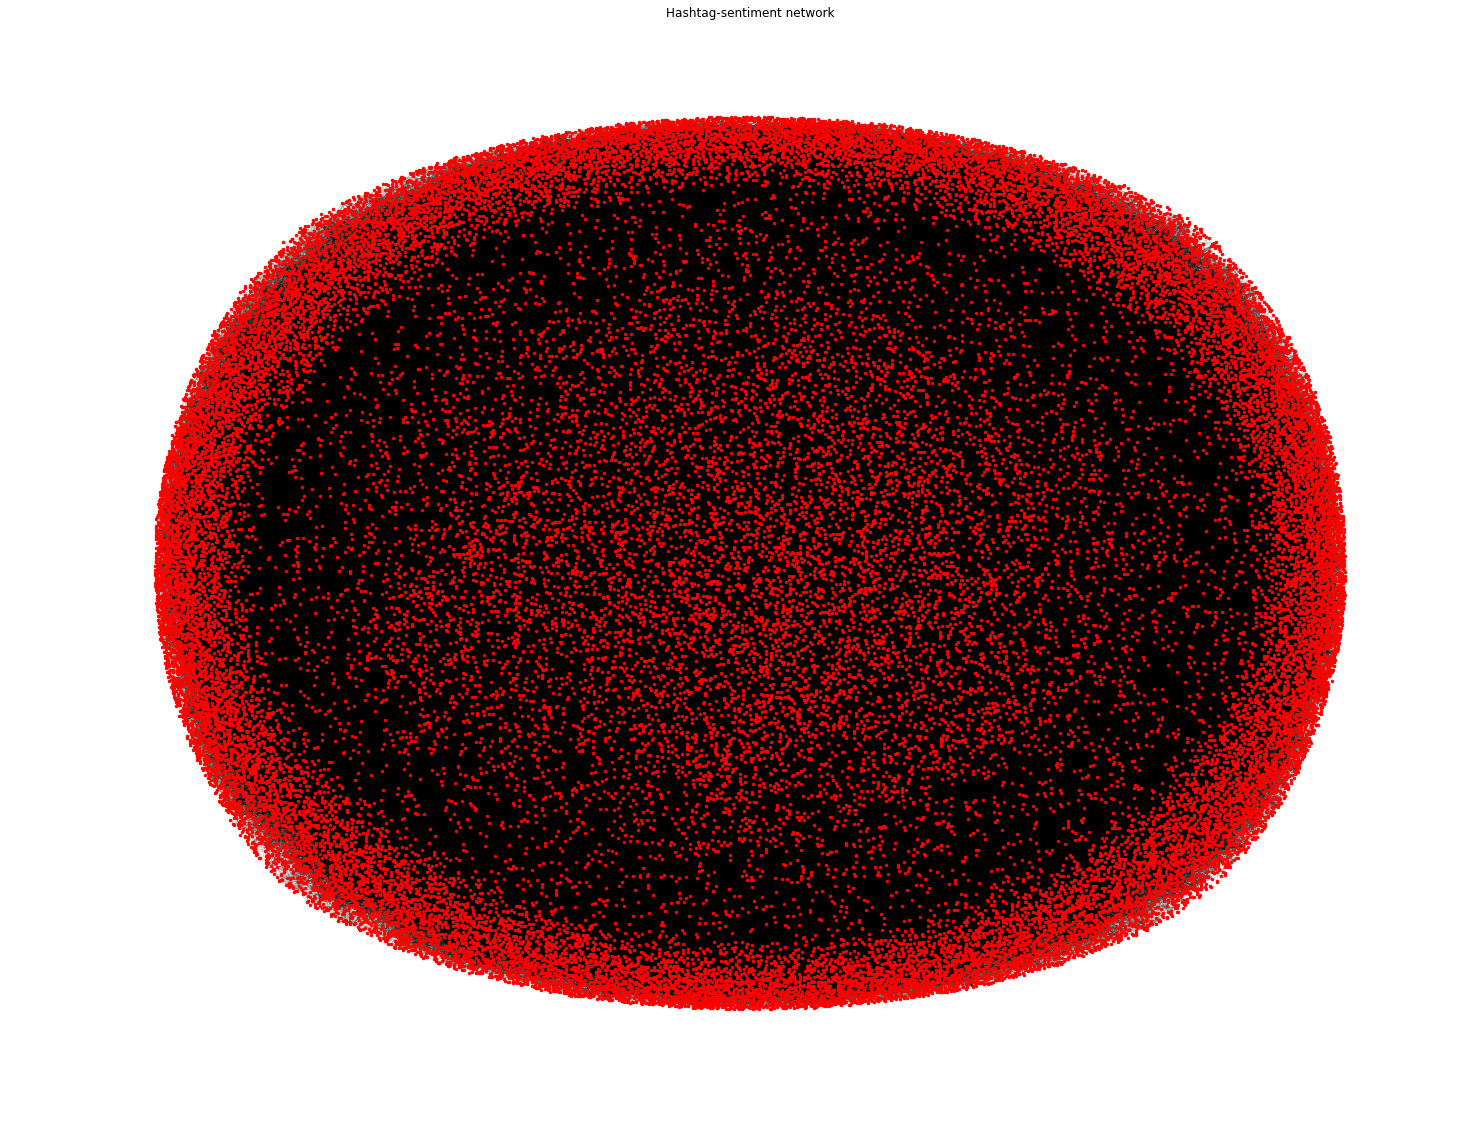

In [111]:
#draw the graph
options = {
     'node_color': 'red',
     'node_size': 6,
     'width': 0.1,
    # 'with_labels':True
}
 
plt.figure(figsize=(20,15)) 
nx.draw(G,nx.spring_layout(G,k = 0.3), **options)
plt.title('Hashtag-sentiment network')
plt.show() 

As mentioned earlier this graph consists of 36.335 nodes and 459.899 edges, whilst the giant connected component (GCC), which we will be working with consists of 22.865 nodes and 456.472 edges. We note that it is difficult to extract any information about the connections from the graph above, but when inspecting the degree distribution as seen in the beginning of this notebook, it becomes clear that this isn't because we are working with an extremely dense network, but simply because we are working with so many nodes. 

One could consider creating a more dense network, by changing the value that determines how similar the sentiment of the connected users must be. E.g. by using 0.5 instead of 0.1, one will obtain a network with 2.079.206 edges, but it is chosen not to do so, because of limited computer power.

### Community detection
Now we wish to find the underlying communities hidden in the GCC, such that we can create words clouds for each of these. These communities/the best partition of the network is found by using the Python Louvain-algorithm implementation:

In [40]:
#find the communities (the best partition): 
GCC = max(nx.connected_component_subgraphs(G), key=len)
partition = community.best_partition(GCC)

#print number of communities and the modularity
count=list(set([i for i in partition.values()]))
print 'The number of communities: %d' % len(count)
print 'The Louvain Modularity: %f' % community.modularity(partition, GCC)

The number of communities: 37
The Louvain Modularity: 0.741012


As seen above 37 communities are found by the algorithm, and the high modularity of M = 0.74 indicates that the community structure is quite good (Barabási, 2015). We visualize the found communities by colouring the nodes in the GCC according to the community they belong to: 

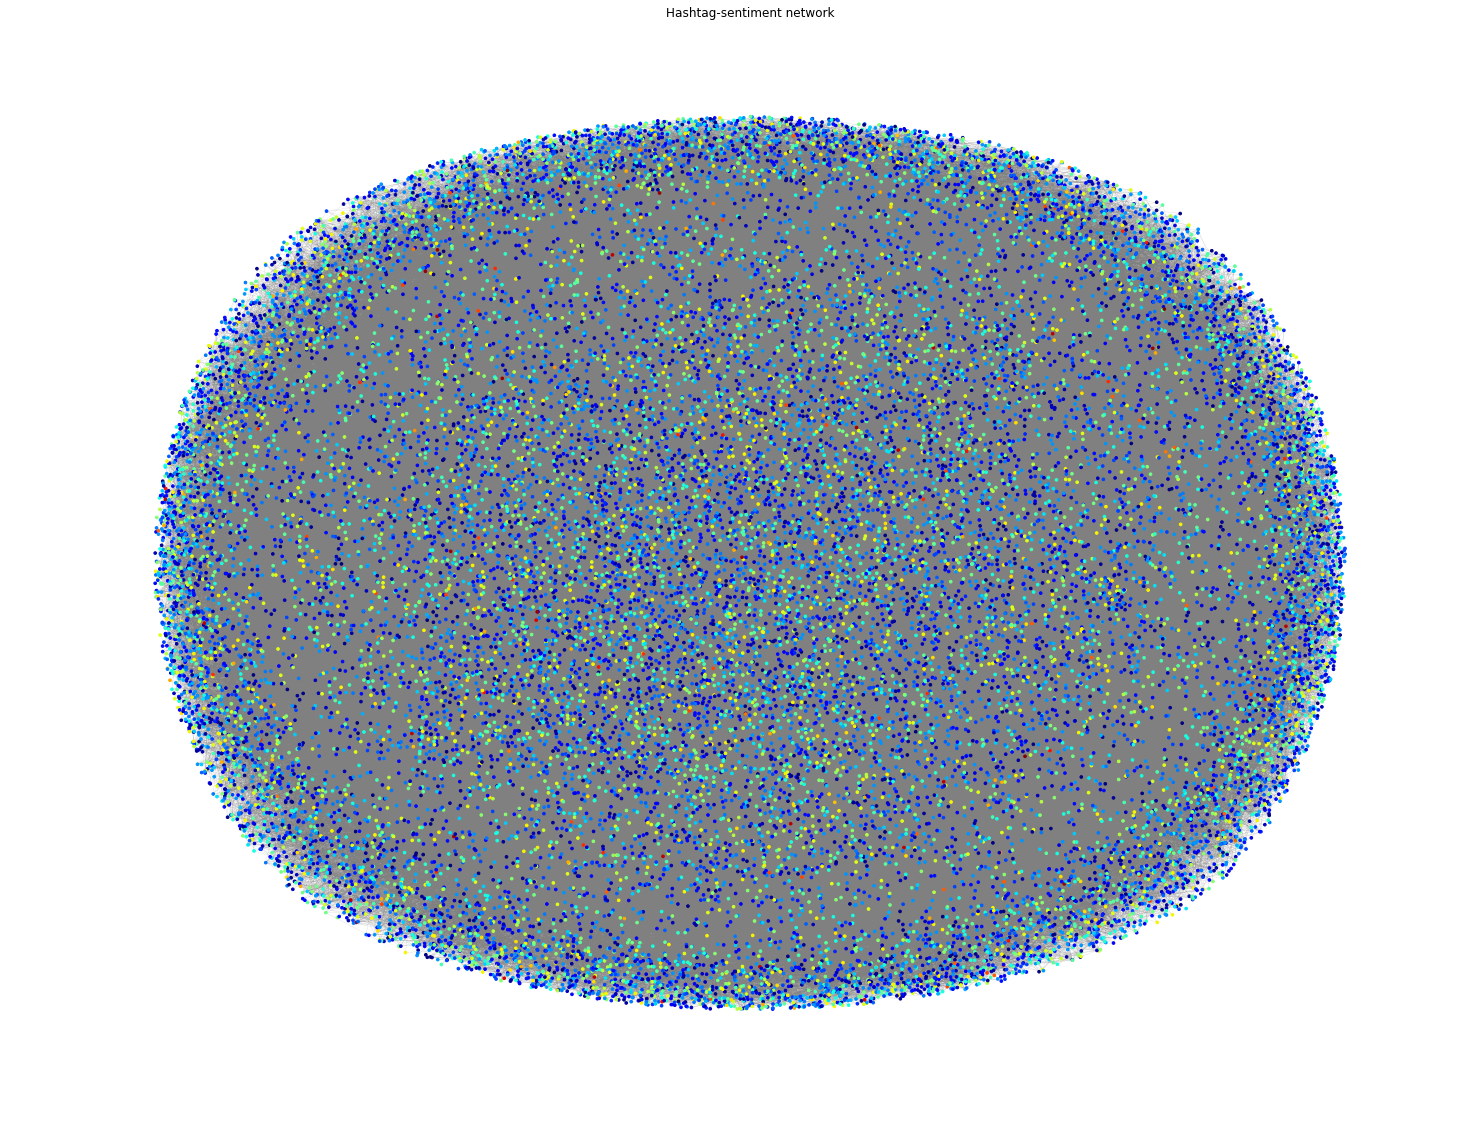

In [126]:
options = {
     'node_color' : list(partition.values()),
     'node_size': 7,
     'cmap': plt.get_cmap('jet'),
     'width': 0.1,
     'edge_color': 'grey'
}

plt.figure(figsize=(20,15)) 
nx.draw(GCC,nx.spring_layout(GCC,k = 0.3), **options)
plt.title('Hashtag-sentiment network')
plt.show()

We investigate this partition, as we are interested in knowing which hashtags occur most often in certain communities and what the average sentiment value of each community is. First we compute the number if nodes in each community: 

In [43]:
#find out how many nodes are in each community:
nodes_in_com = Counter(partition.values())

print 'The number of nodes in each community:'
nodes_in_com


The number of nodes in each community:


Counter({0: 807,
         1: 918,
         2: 1838,
         3: 726,
         4: 1370,
         5: 2187,
         6: 1768,
         7: 1705,
         8: 714,
         9: 2252,
         10: 596,
         11: 731,
         12: 454,
         13: 702,
         14: 251,
         15: 929,
         16: 382,
         17: 458,
         18: 1037,
         19: 4,
         20: 457,
         21: 652,
         22: 271,
         23: 698,
         24: 563,
         25: 153,
         26: 14,
         27: 88,
         28: 10,
         29: 10,
         30: 30,
         31: 32,
         32: 20,
         33: 4,
         34: 18,
         35: 12,
         36: 4})

And for a given community we can figure out which node has the highest degree within that community (here shown for community 0):

In [191]:
nodes = [k for k,v in partition.iteritems() if v == comm_number[0]]

#create subgraph of the community: 
subcomm = G.subgraph(nodes)
degree_dict = subcomm.degree()
[(k,v) for v, k in sorted(((v, k) for k, v in degree_dict.items()), reverse=True)]

[(u'BarneyS', 300),
 (u'IamJRushing', 298),
 (u'PJDonnelly15', 296),
 (u'gabshaklar', 294),
 (u'tcampion11', 287),
 (u'Josh_VanKell_', 282),
 (u'mesu91', 272),
 (u'HelloPixelPup', 271),
 (u'mayur1318', 270),
 (u'KatieRyan4', 270),
 (u'MattWithTw0Ts', 262),
 (u'Carmong15', 262),
 (u'fornitin', 261),
 (u'LilMac01', 259),
 (u'nl_hill', 258),
 (u'iisamartinez', 258),
 (u'FGranthon', 258),
 (u'epjr262', 257),
 (u'dmunir12', 257),
 (u'GeekingOutCrew', 257),
 (u'AgusYoungHeezy', 257),
 (u'victoriakwan_', 256),
 (u'andrewgrange6', 256),
 (u'Natali_Muzzy', 256),
 (u'jdeezy__', 255),
 (u'haley_apel', 255),
 (u'avni79', 255),
 (u'EricJ319', 255),
 (u'Ayotee__', 255),
 (u'gzusurzua', 254),
 (u'alenaguerrero30', 254),
 (u'JLic702', 254),
 (u'yosoycatire', 253),
 (u'filmbuffz', 253),
 (u'carmlewis', 253),
 (u'adrianrivera66', 253),
 (u'_santiagocastro', 253),
 (u'Waandys', 253),
 (u'BloomReports', 253),
 (u'acoots97', 252),
 (u'Vinabha_bishen', 252),
 (u'ShorterPorter08', 252),
 (u'MP12striker', 252

We then compute the average sentiment value for the found communities: 

In [42]:
#compute average sentiment value for the communities: 

sentiment_dict = {}

#community number for the 10 biggest communities:
comm_number = nodes_in_com.keys() #[10, 5, 2, 7, 9, 4, 14, 17, 1, 0]

#loop through each community and save the average sentiment value for each
for i in range(0,len(comm_number)):

    #find the nodes in the given community:
    nodes = [k for k,v in partition.iteritems() if v == comm_number[i]]

    #find sentiment in each node and compute average:
    node_sentiment = [GCC.node[element]['sentiment'] for element in nodes]
    average_sentiment = np.average(node_sentiment)

    #save in dict
    sentiment_dict[comm_number[i]] = average_sentiment
    
print 'The average sentiment value for the 37 communities:'
sentiment_dict

The average sentiment value for the 37 communities:


{0: 5.6847382097276542,
 1: 5.5751690952297848,
 2: 5.6693759776592643,
 3: 5.5351010343811984,
 4: 5.7313061748206575,
 5: 6.4293842882783103,
 6: 4.9425566540435275,
 7: 5.1142745396318743,
 8: 6.147716391738185,
 9: 5.658169933118117,
 10: 5.2654123618477229,
 11: 5.2809576037457138,
 12: 5.0167709686721054,
 13: 5.5005882636057057,
 14: 6.1029405237128058,
 15: 5.0359334322160638,
 16: 4.0767369179201642,
 17: 5.265322614539178,
 18: 6.1228793572462301,
 19: 5.9736666666666665,
 20: 5.3871636485239724,
 21: 5.9481064026190733,
 22: 5.5942402174974122,
 23: 5.9316509013815972,
 24: 5.9965416049266302,
 25: 5.5996188130920155,
 26: 5.015714285714286,
 27: 5.8119574109602521,
 28: 5.9010476190476187,
 29: 4.4231428571428566,
 30: 7.5191944444444436,
 31: 6.2765243844696972,
 32: 5.3821781746031743,
 33: 4.3512500000000003,
 34: 7.1167524250440914,
 35: 4.7773134920634925,
 36: 5.0404761904761903}

We can also try coloring the nodes in a given community based on their sentiment-values, here done for community 0: 

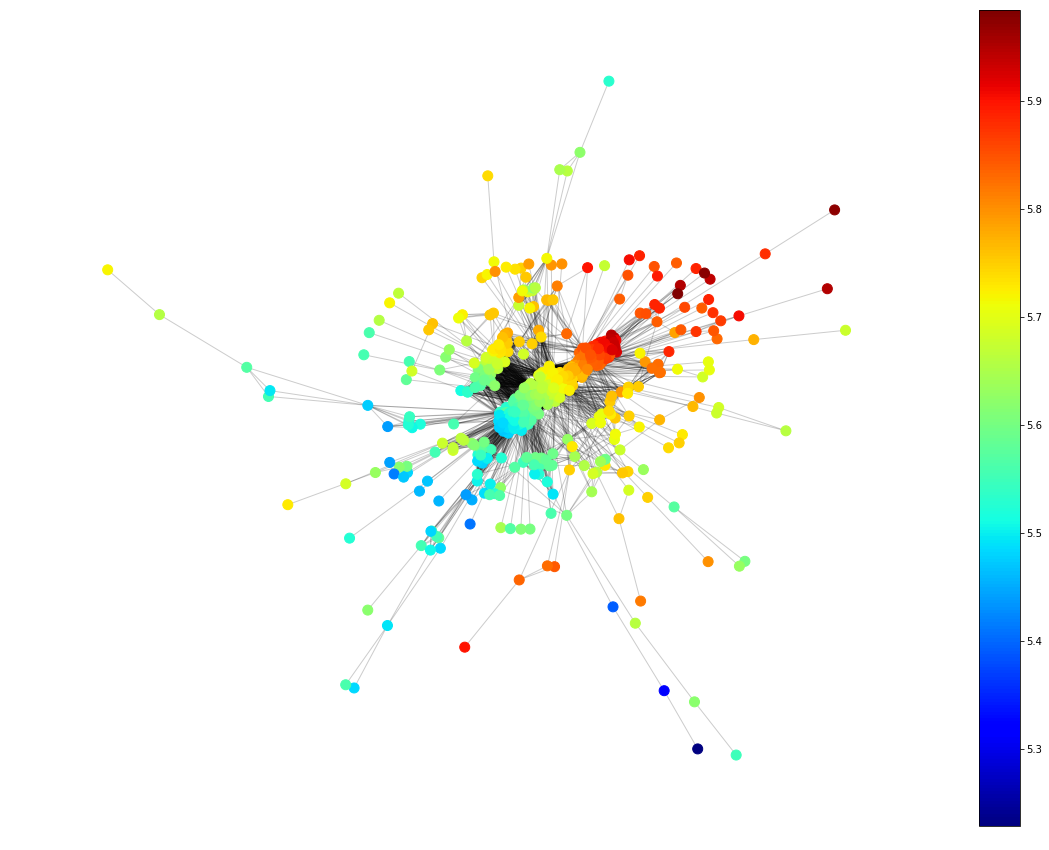

In [192]:
#find nodes
nodes = [k for k,v in partition.iteritems() if v == comm_number[0]]

#create subgraph of the community: 
subcomm = G.subgraph(nodes)
degree_dict = subcomm.degree()
[(k,v) for v, k in sorted(((v, k) for k, v in degree_dict.items()), reverse=True)]

#find sentiment
values = [subcomm.node[node]['sentiment'] for node in subcomm.nodes()]

#plot
plt.figure(figsize=(20,15)) 
pos = nx.spring_layout(subcomm)
ec = nx.draw_networkx_edges(subcomm, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(subcomm, pos, node_color = values, 
                            with_labels=False, node_size=100, cmap=plt.cm.jet)
plt.colorbar(nc)
plt.axis('off')
plt.show()

Where we very neatly see that the nodes only are connected to nodes with similar sentiment values. We find the most common hashtags in the found communities: 

In [44]:
#compute most common hashtags in the communities: 

hashtag_dict = {}

#loop through each community and save the most common hashtags for each
for i in range(0,len(comm_number)):

    #find the nodes in the given community:
    nodes = [k for k,v in partition.iteritems() if v == comm_number[i]]

    #find hashtag in each node and find the most common
    node_hash = [GCC.node[element]['hashtag'] for element in nodes]
    hashlist = [item for sublist in node_hash for item in sublist]   #flatten list

    mostcommon= [word for word, word_count in Counter(hashlist).most_common(3)]

    #save in dict
    hashtag_dict[comm_number[i]] = mostcommon
    
print 'The 3 most common hashtag in for the 37 communities:'
hashtag_dict


The 3 most common hashtag in for the 37 communities:


{0: [u'legendary', u'suitup', u'waitforit'],
 1: [u'spoilers', u'spoileralert', u'feels'],
 2: [u'barney', u'robin', u'ted'],
 3: [u'finalepisode', u'fb', u'legenwaitforitdary'],
 4: [u'himymwedding', u'lastforever', u'daisy'],
 5: [u'tedmosby', u'love', u'barneystinson'],
 6: [u'sad', u'finale', u'disappointed'],
 7: [u'legendary', u'barneystinson', u'barney'],
 8: [u'legendary', u'suitup', u'legenwaitforitdary'],
 9: [u'psych', u'thewalkingdead', u'twd'],
 10: [u'lastforever', u'farewellhimym', u'nw'],
 11: [u'seriesfinale', u'endofanera', u'theend'],
 12: [u'ccavm', u'spoiler', u'comoconociavuestramadre'],
 13: [u'finale', u'crying', u'tears'],
 14: [u'lastforever', u'insidetheactorstudio', u'allthefeels'],
 15: [u'lost', u'dexter', u'twd'],
 16: [u'legendary', u'crying', u'lost'],
 17: [u'fwbl', u'bluefrenchhorn', u'seasonfinale'],
 18: [u'fwbl', u'paleyfest', u'cbs'],
 19: [u'askthekids'],
 20: [u'wtf', u'aprilfools', u'goodbyehimym'],
 21: [u'friends', u'truestory', u'seinfeld'],

### Creating wordclouds
We will now create wordclouds, and hopefully find connections between the most used hashtags, average sentiment value and the words in the cloud for each community. 

Word clouds are created by computing TF-IDF values for each word. TF-IDF (term frequency-inverse document frequence) is a numerical statistic, that is intended to reflect how important a word is to a document in a collection of documents (wiki, 2017) - or in our case: how important a word is to the words in a community in a collection of communities.

TF-IDF consists of 2 terms: TF and IDF. TF (term frequency) describes the number of times a word occurs in a community. IDF (inverse document frequency) is a factor that diminishes the weight of words that occur very frequently in the communities (could e.g. be 'Ted', 'mother', 'episode' or 'finale'), and increases the weight of terms that occur rarely.

It is chosen to simply let TF be the raw count of a word within a community, and to let IDF be: log(no_of_communities/no_of_communities_word_occurs_in). We therefore set up functions that compute TF-IDF and plot a word cloud based on the TF-IDF results:

In [147]:
#first we compute TF (which is chosen to be the raw count of a word) for every community, and save the result in a single list: 

TF_list = []

for i in range(0,len(comm_number)):
    
    #find the nodes in the given community:
    nodes = [k for k,v in partition.iteritems() if v == comm_number[i]]

    #find tokens in each node , and create a flattened list
    combined_tokens = [G.node[element]['tokens'] for element in nodes]
    combined_tokens = [item for sublist in combined_tokens for item in sublist]   #flatten list
    
    #compute TF and add to list
    TF = nltk.FreqDist(combined_tokens)
    TF_list.append(TF)

#to compute the IDF we must first count how many communities a given word occurs in: 
WordOccurrances = {}

for TF in TF_list:
    for word in TF.keys():
        if word in WordOccurrances:
            WordOccurrances[word] += 1
        else:
            WordOccurrances[word] = 1
            
#function that converts TF-IDF result to a string, where each word is repeated according to its TF-IDF score:
def generateString(tfidf):
    result = ""
    for word, td_idf in tfidf.iteritems():
        result += (word + " ") * int(round(td_idf))
    return result

#function that computes the final Tf-IDF and plots the wordcloud    
def createWordcloud(TF):
    tf_idf = {}
    for key, value in TF.iteritems():
        tf_idf[key] = value * math.log(float(len(comm_number)/WordOccurrances[key]))

    #convert tf-idf to a string and create word cloud
    string = generateString(tf_idf)
    wordcloud = WordCloud(background_color="white",width=1920, height=1080,collocations = False).generate(string)
    plt.figure(figsize = (20,20))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.show()

One can then simply create a word cloud by calling the following - here seen for the 0th community: 

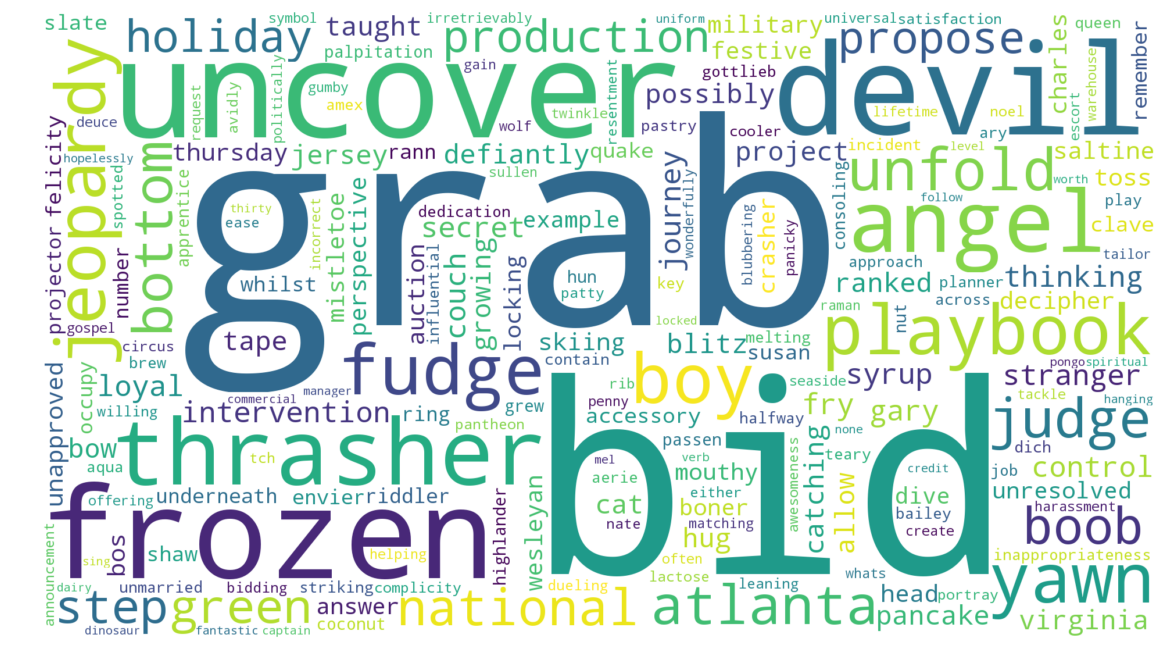

In [189]:
createWordcloud(TF_list[0])

When using TF-IDF's there is put emphasis on the words that occur in the given community, but not in the others. In the word cloud above we therefore also see huge words, that doesn't necessarily have anything do with HIMYM, such as frozen, angel, jeopardy and atlanta. The average sentiment value for the given community is 5.68 and the most used hashtags is #legendary, #suitup and #waitforit, which also can be seen in the word cloud which seems to express 'legendary things', such as 'pancakes', 'boobs', 'holidays', 'the playbook', 'the saltine challenge' and the fact that Marshall ('fudge') is going to be a 'judge'. This could explain why some of the words seem out of context - simply that people in other cases of life could use the hashtags #legendary or #suitup and then also include #himym, even if that is not what they are tweeting about. 

Just for fun we below draw the word cloud for the same community but only considering the TF-values. We then clearly see that the occuring words aren't very descriptive of a given community, as these occur in most communities, such as 'finale', 'farewell', 'episode' and 'mother', but it becomes more clear that it is actually HIMYM that people are tweeting about.

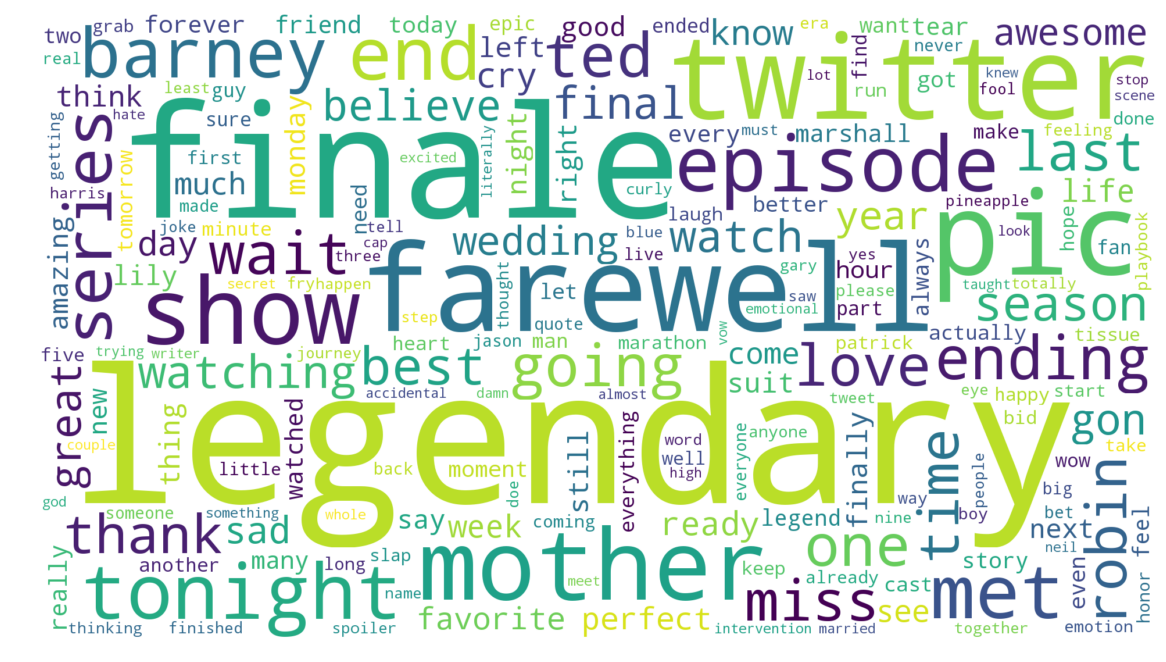

In [146]:
createWordcloud(TF_list[0])

## References:

Barábasi, A. L. (2015): 'Network science', webpage: http://barabasi.com/networksciencebook/, chapter 9